# Benchmarking RL methods to solve BlackJack

Thomas Lemercier & Gaspard Berthelier

## Imports

In [1]:
# from google.colab import drive
# drive.mount("/content/drive")
# %cd /content/drive/MyDrive/RL/blackjack

In [1]:
import gym
import time
from tqdm import tqdm
import numpy as np

In [2]:
from src.utils.general import state_to_index, get_num_states, state_to_tensor_encoding
from src.utils.data_struct import Transition
from src.agents import Agent
from src.utils.visualization import plot_policy_simple_blackjack


def play_episode(env: gym.Env, agent: Agent, render: bool = False, array_encoding: bool = False):
    """plays one episode of given agent"""
    state = env.reset()
    if render:
        env.render()
    if array_encoding:
        state = state_to_tensor_encoding(state, env.observation_space)
    else:
        state = state_to_index(state, env.observation_space)
    terminated = False
    while not terminated:
        action = agent.get_best_action(state)
        next_state, reward, terminated, _, _ = env.step(action)
        if render:
            env.render()
        if array_encoding:
            next_state = state_to_tensor_encoding(next_state, env.observation_space)
        else:
            next_state = state_to_index(next_state, env.observation_space)
        state = next_state
    return reward

In [3]:
def play_policy(env: gym.Env, agent: Agent, n_test_episodes: int,  array_encoding: bool = False):
  """test the agent's policy on multiple episodes, prints the last one"""
  rewards = [play_episode(env, agent, render= i == n_test_episodes-1, array_encoding=array_encoding) for i in range(n_test_episodes)]
  rewards = np.array(rewards)
  n_wins = np.sum(rewards == 1)
  n_draws = np.sum(rewards == 0)
  print(f"Win rate: {n_wins / n_test_episodes:.4f}")
  print(f"Draw rate: {n_draws / n_test_episodes:.4f}")

In [4]:
n_episodes = 500_000
n_test_episodes = 100_000

## Infinite Deck

Infinite deck, aka probabilities of drawing each card remains constant

In [18]:
from src.envs import InfiniteSimpleBlackjack
env = InfiniteSimpleBlackjack(seed=42)

### Random

Random agent which takes action randomly at each step

In [19]:
from src.agents import RandomAgent

agent = RandomAgent(env.action_space)
play_policy(env, agent, n_test_episodes)


Player's hand: [2, 10] (value: 12)
Dealer's hand: [10, 9] (value: 19)
Current state: [12 10  0]


Player's hand: [2, 10] (value: 12)
Dealer's hand: [10, 9] (value: 19)
Current state: [12 10  0]

Win rate: 0.2782
Draw rate: 0.0412


### Sarsa

In [20]:
from src.explorations import EpsilonGreedy, UCB
from src.utils.data_struct import SarsaParameters
from src.agents import SarsaAgent

def main_sarsa(env: gym.Env, agent: SarsaAgent, n_episodes: int):
    start = time.time()
    n_wins = 0
    n_draws = 0
    for _ in tqdm(range(n_episodes)):
        state = env.reset()
        state = state_to_index(state, env.observation_space)
        terminated = False
        action = agent.act(state)
        while not terminated:
            next_state, reward, terminated, _, _ = env.step(action)
            next_state = state_to_index(next_state, env.observation_space)

            transition = Transition(state=state, action=action, next_state=next_state, reward=reward, done=terminated)

            action = agent.act(next_state)
            state = next_state
            agent.step(transition, action)

        if reward == 1:
            n_wins += 1
        elif reward == 0:
            n_draws += 1

    print(f"Win rate: {n_wins / n_episodes:.4f}")
    print(f"Draw rate: {n_draws / n_episodes:.4f}")

    print(f"\nTime taken: {time.time() - start:.4f} seconds")

In [21]:
exploration = UCB(num_states=get_num_states(env.observation_space), num_actions=env.action_space.n, seed=42)
sarsa_parameters = SarsaParameters(num_states=get_num_states(env.observation_space), num_actions=env.action_space.n, alpha=0.05, gamma=0.9)
agent = SarsaAgent(sarsa_parameters, exploration)

main_sarsa(env, agent, n_episodes)

100%|██████████| 500000/500000 [01:16<00:00, 6521.81it/s]

Win rate: 0.3700
Draw rate: 0.0805

Time taken: 76.6689 seconds


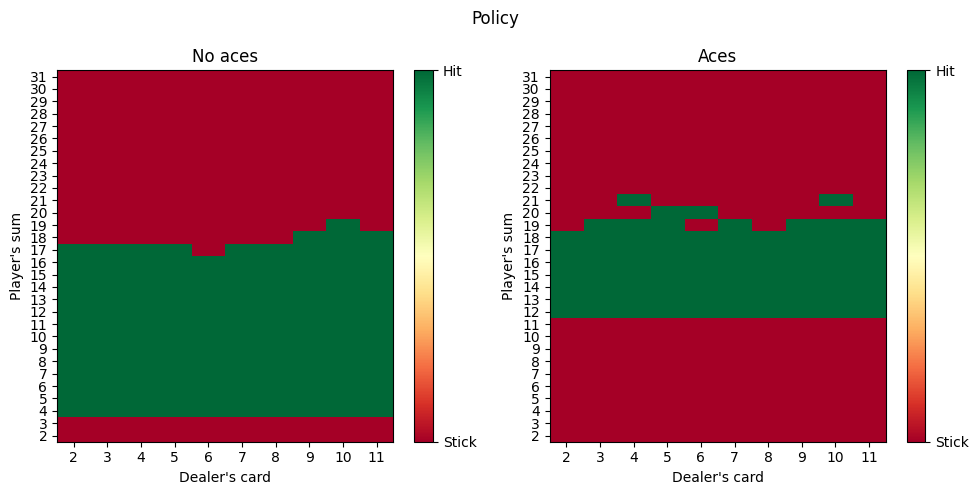


Player's hand: [10, 8] (value: 18)
Dealer's hand: [10, 10] (value: 20)
Current state: [18 10  0]


Player's hand: [10, 8, 10] (value: 28)
Dealer's hand: [10, 10] (value: 20)
Current state: [28 10  0]

Win rate: 0.3610
Draw rate: 0.0783


In [22]:
policy = agent.get_policy()
plot_policy_simple_blackjack(policy, env.observation_space)

play_policy(env, agent, n_test_episodes)

In [24]:
exploration = EpsilonGreedy(epsilon=0.1, decay=1, seed=42)
sarsa_parameters = SarsaParameters(num_states=get_num_states(env.observation_space), num_actions=env.action_space.n, alpha=0.05, gamma=0.9)
agent = SarsaAgent(sarsa_parameters, exploration)

main_sarsa(env, agent, n_episodes)

100%|██████████| 500000/500000 [00:32<00:00, 15200.40it/s]


Win rate: 0.3678
Draw rate: 0.0787

Time taken: 32.8949 seconds

Player's hand: [8, 10] (value: 18)
Dealer's hand: [6, 10] (value: 16)
Current state: [18  6  0]


Player's hand: [8, 10] (value: 18)
Dealer's hand: [6, 10, 5] (value: 21)
Current state: [18  6  0]

Win rate: 0.3822
Draw rate: 0.0842


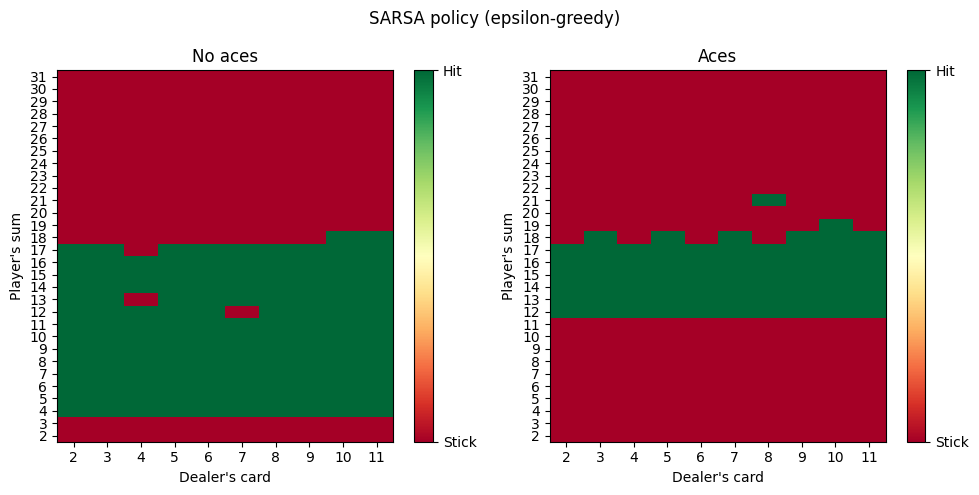


Player's hand: [10, 10] (value: 20)
Dealer's hand: [11, 4] (value: 15)
Current state: [20 11  0]


Player's hand: [10, 10] (value: 20)
Dealer's hand: [11, 4, 7, 10] (value: 22)
Current state: [20 11  0]

Win rate: 0.3826
Draw rate: 0.0860


In [25]:
policy = agent.get_policy()
plot_policy_simple_blackjack(policy, env.observation_space, title="SARSA policy (epsilon-greedy)")

play_policy(env, agent, n_test_episodes)

### Q Learning

In [26]:
from src.agents import QlearningAgent
from src.utils.data_struct import QlearningParameters

def main_qlearning(env: gym.Env, agent: QlearningAgent, n_episodes: int):
    start = time.time()
    n_wins = 0
    n_draws = 0
    for _ in tqdm(range(n_episodes)):
        state = env.reset()
        state = state_to_index(state, env.observation_space)
        terminated = False
        while not terminated:
            action = agent.act(state)
            next_state, reward, terminated, _, _ = env.step(action)
            next_state = state_to_index(next_state, env.observation_space)

            transition = Transition(state=state, action=action, next_state=next_state, reward=reward, done=terminated)

            state = next_state
            agent.step(transition)

        if reward == 1:
            n_wins += 1
        elif reward == 0:
            n_draws += 1

    print(f"Win rate: {n_wins / n_episodes:.4f}")
    print(f"Draw rate: {n_draws / n_episodes:.4f}")
    print(f"\nTime taken: {time.time() - start:.4f} seconds")

In [27]:
exploration = UCB(num_states=get_num_states(env.observation_space), num_actions=env.action_space.n, seed=42)
qlearning_parameters = QlearningParameters(num_states=get_num_states(env.observation_space), num_actions=env.action_space.n, alpha=0.05, gamma=0.9)
agent = QlearningAgent(qlearning_parameters, exploration)

main_qlearning(env, agent, n_episodes)

100%|██████████| 500000/500000 [01:03<00:00, 7886.75it/s]

Win rate: 0.3762
Draw rate: 0.0804

Time taken: 63.3995 seconds


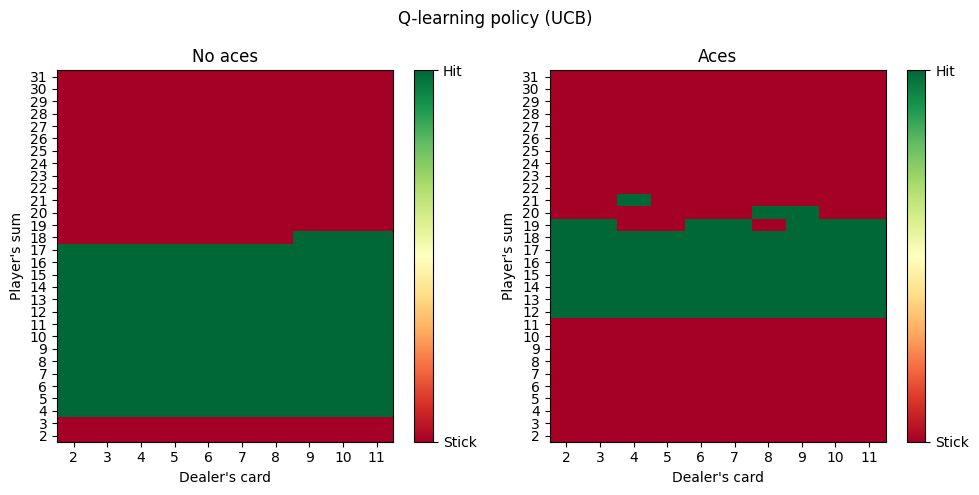


Player's hand: [8, 9] (value: 17)
Dealer's hand: [10, 9] (value: 19)
Current state: [17 10  0]


Player's hand: [8, 9, 10] (value: 27)
Dealer's hand: [10, 9] (value: 19)
Current state: [27 10  0]

Win rate: 0.3749
Draw rate: 0.0818


In [28]:
policy = agent.get_policy()
plot_policy_simple_blackjack(policy, env.observation_space, title="Q-learning policy (UCB)")

play_policy(env, agent, n_test_episodes)

In [29]:
exploration = EpsilonGreedy(epsilon=0.1, decay=1, seed=42)
qlearning_parameters = QlearningParameters(num_states=get_num_states(env.observation_space), num_actions=env.action_space.n, alpha=0.05, gamma=0.9)
agent = QlearningAgent(qlearning_parameters, exploration)

main_qlearning(env, agent, n_episodes)

100%|██████████| 500000/500000 [00:39<00:00, 12585.54it/s]

Win rate: 0.3710
Draw rate: 0.0788

Time taken: 39.7311 seconds


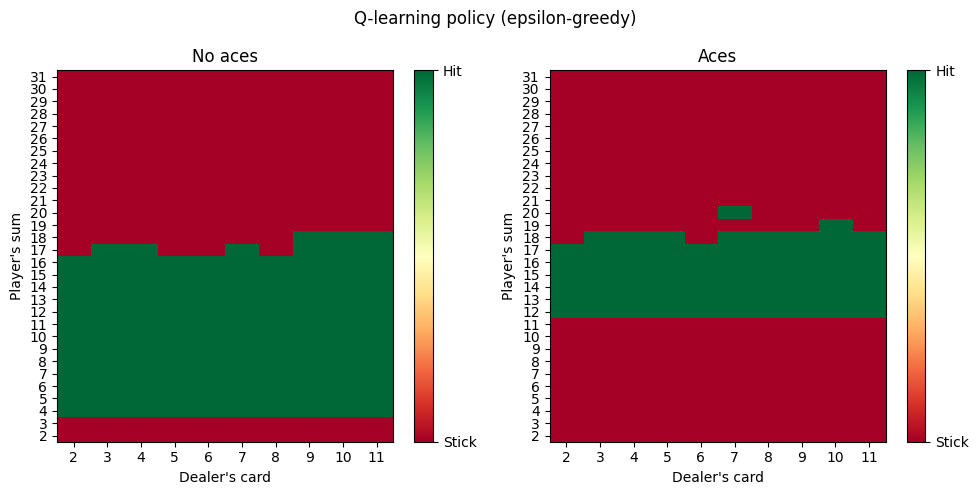


Player's hand: [11, 2] (value: 13)
Dealer's hand: [8, 10] (value: 18)
Current state: [13  8  1]


Player's hand: [11, 2, 6] (value: 19)
Dealer's hand: [8, 10] (value: 18)
Current state: [19  8  1]


Player's hand: [11, 2, 6] (value: 19)
Dealer's hand: [8, 10] (value: 18)
Current state: [19  8  1]

Win rate: 0.3864
Draw rate: 0.0861


In [30]:
policy = agent.get_policy()
plot_policy_simple_blackjack(policy, env.observation_space, title="Q-learning policy (epsilon-greedy)")

play_policy(env, agent, n_test_episodes)

## Simple Finite

In [31]:
from src.envs import SimpleBlackjack
env = SimpleBlackjack(seed=42, packs=4)

### Random

In [32]:
agent = RandomAgent(env.action_space, seed=42)
play_policy(env, agent, n_test_episodes)


Player's hand: [11, 2] (value: 13)
Dealer's hand: [10, 7] (value: 17)
Current state: [13 10  1  2]


Player's hand: [11, 2, 9] (value: 12)
Dealer's hand: [10, 7] (value: 17)
Current state: [12 10  0  3]


Player's hand: [11, 2, 9, 5] (value: 17)
Dealer's hand: [10, 7] (value: 17)
Current state: [17 10  0  4]


Player's hand: [11, 2, 9, 5] (value: 17)
Dealer's hand: [10, 7] (value: 17)
Current state: [17 10  0  4]

Win rate: 0.2791
Draw rate: 0.0414


### Sarsa

In [33]:
exploration = UCB(num_states=get_num_states(env.observation_space), num_actions=env.action_space.n, seed=42)
sarsa_parameters = SarsaParameters(num_states=get_num_states(env.observation_space), num_actions=env.action_space.n, alpha=0.05, gamma=0.9)
agent = SarsaAgent(sarsa_parameters, exploration)

main_sarsa(env, agent, n_episodes)

100%|██████████| 500000/500000 [01:59<00:00, 4169.54it/s]

Win rate: 0.3786
Draw rate: 0.0812

Time taken: 119.9192 seconds


In [34]:
policy = agent.get_policy()
play_policy(env, agent, n_test_episodes)


Player's hand: [2, 6] (value: 8)
Dealer's hand: [8, 10] (value: 18)
Current state: [8 8 0 2]


Player's hand: [2, 6, 8] (value: 16)
Dealer's hand: [8, 10] (value: 18)
Current state: [16  8  0  3]


Player's hand: [2, 6, 8, 10] (value: 26)
Dealer's hand: [8, 10] (value: 18)
Current state: [26  8  0  4]

Win rate: 0.3776
Draw rate: 0.0821


In [35]:
exploration = EpsilonGreedy(epsilon=0.1, decay=1, seed=42)
sarsa_parameters = SarsaParameters(num_states=get_num_states(env.observation_space), num_actions=env.action_space.n, alpha=0.05, gamma=0.9)
agent = SarsaAgent(sarsa_parameters, exploration)

main_sarsa(env, agent, n_episodes)

policy = agent.get_policy()
play_policy(env, agent, n_test_episodes)

100%|██████████| 500000/500000 [01:19<00:00, 6293.42it/s]


Win rate: 0.3704
Draw rate: 0.0790

Time taken: 79.4533 seconds

Player's hand: [11, 7] (value: 18)
Dealer's hand: [7, 3] (value: 10)
Current state: [18  7  1  2]


Player's hand: [11, 7] (value: 18)
Dealer's hand: [7, 3, 2, 10] (value: 22)
Current state: [18  7  1  2]

Win rate: 0.3880
Draw rate: 0.0828


### Q Learning

In [36]:
exploration = UCB(num_states=get_num_states(env.observation_space), num_actions=env.action_space.n, seed=42)
qlearning_parameters = QlearningParameters(num_states=get_num_states(env.observation_space), num_actions=env.action_space.n, alpha=0.05, gamma=0.9)
agent = QlearningAgent(qlearning_parameters, exploration)

main_qlearning(env, agent, n_episodes)

policy = agent.get_policy()
play_policy(env, agent, n_test_episodes)

100%|██████████| 500000/500000 [01:53<00:00, 4401.64it/s]


Win rate: 0.3803
Draw rate: 0.0828

Time taken: 113.5971 seconds

Player's hand: [10, 3] (value: 13)
Dealer's hand: [10, 5] (value: 15)
Current state: [13 10  0  2]


Player's hand: [10, 3, 5] (value: 18)
Dealer's hand: [10, 5] (value: 15)
Current state: [18 10  0  3]


Player's hand: [10, 3, 5, 8] (value: 26)
Dealer's hand: [10, 5] (value: 15)
Current state: [26 10  0  4]

Win rate: 0.3819
Draw rate: 0.0815


In [37]:
exploration = EpsilonGreedy(epsilon=0.1, decay=1, seed=42)
qlearning_parameters = QlearningParameters(num_states=get_num_states(env.observation_space), num_actions=env.action_space.n, alpha=0.05, gamma=0.9)
agent = QlearningAgent(qlearning_parameters, exploration)

main_qlearning(env, agent, n_episodes)

policy = agent.get_policy()
play_policy(env, agent, n_test_episodes)

100%|██████████| 500000/500000 [01:16<00:00, 6551.05it/s]


Win rate: 0.3714
Draw rate: 0.0789

Time taken: 76.3259 seconds

Player's hand: [7, 10] (value: 17)
Dealer's hand: [5, 4] (value: 9)
Current state: [17  5  0  2]


Player's hand: [7, 10, 10] (value: 27)
Dealer's hand: [5, 4] (value: 9)
Current state: [27  5  0  3]

Win rate: 0.3805
Draw rate: 0.0818


## Complete

In [5]:
from src.envs import Blackjack
env = Blackjack(seed=42)

### Random

In [6]:
from src.agents import RandomAgent

agent = RandomAgent(env.action_space)
play_policy(env, agent, n_test_episodes, array_encoding=True)


Player's hand: [10, 7] (value: 17)
Dealer's hand: [7, 9] (value: 16)
Current state: {'dealer': 7, 'player': [10, 7]}


Player's hand: [10, 7] (value: 17)
Dealer's hand: [7, 9, 5] (value: 21)
Current state: {'dealer': 7, 'player': [10, 7]}

Win rate: 0.2792
Draw rate: 0.0418


### DQN

In [19]:
from src.agents.dqn import DQN
from src.utils.general import get_input_dim_encoding
import torch

def main_dqn(env: gym.Env, agent: DQN, n_episodes: int):
    start = time.time()
    n_wins = 0
    n_draws = 0
    for _ in tqdm(range(n_episodes)):
        state = env.reset()
        state = state_to_tensor_encoding(state, env.observation_space)
        terminated = False
        while not terminated:
            action = agent.act(state)
            next_state, reward, terminated, _, _ = env.step(action)

            next_state = state_to_tensor_encoding(next_state, env.observation_space)
            action = torch.Tensor([action]).long()
            reward = torch.Tensor([reward]).float()
            terminated = torch.Tensor([terminated]).float()

            transition = Transition(state=state, action=action, next_state=next_state, reward=reward, done=terminated)

            state = next_state
            agent.step(transition)

        if reward == 1:
            n_wins += 1
        elif reward == 0:
            n_draws += 1

    print(f"Win rate: {n_wins / n_episodes:.2f}")
    print(f"Draw rate: {n_draws / n_episodes:.2f}")

    print(f"\nTime taken: {time.time() - start:.2f} seconds")

In [56]:
n_episodes = 100_000

In [57]:
from src.utils.data_struct import DQNParameters
from src.networks import MLP
from src.utils.buffer import ReplayBuffer

params = DQNParameters(batch_size=32, gamma=0.9, freq_target_update=100, device="cpu")
q_network = MLP(get_input_dim_encoding(env.observation_space), 64, env.action_space.n).to(params.device)
target_network = MLP(get_input_dim_encoding(env.observation_space), 64, env.action_space.n).to(params.device)
target_network.load_state_dict(q_network.state_dict())
replay_buffer = ReplayBuffer(10_000)
optimizer = torch.optim.AdamW(q_network.parameters(), lr=0.001, weight_decay=0.0001)
criterion = torch.nn.MSELoss()
exploration = EpsilonGreedy(epsilon=0.1, decay=1, seed=42)

agent = DQN(q_network, target_network, replay_buffer, optimizer, criterion, exploration, params)
main_dqn(env, agent, n_episodes)


100%|██████████| 100000/100000 [07:11<00:00, 231.76it/s]

Win rate: 0.31
Draw rate: 0.05

Time taken: 431.49 seconds


TypeError: play_episode() got an unexpected keyword argument 'array_encoding'

In [59]:

play_policy(env, agent, n_test_episodes, array_encoding=True)


Player's hand: [9, 9] (value: 18)
Dealer's hand: [6, 7] (value: 13)
Current state: {'dealer': 6, 'player': [9, 9]}


Player's hand: [9, 9] (value: 18)
Dealer's hand: [6, 7, 4] (value: 17)
Current state: {'dealer': 6, 'player': [9, 9]}

Win rate: 0.3565
Draw rate: 0.0546


### DQN sequence

In [45]:
from src.utils.general import state_to_tensor_sequence

def main(env: gym.Env, agent: DQN, n_episodes: int):
    start = time.time()
    n_wins = 0
    n_draws = 0
    for _ in tqdm(range(n_episodes)):
        state = env.reset()
        state = state_to_tensor_sequence(state, env.observation_space, env.max_number_of_cards)
        terminated = False
        while not terminated:
            action = agent.act(state)
            next_state, reward, terminated, _, _ = env.step(action)

            next_state = state_to_tensor_sequence(next_state, env.observation_space, env.max_number_of_cards)
            action = torch.Tensor([action]).long()
            reward = torch.Tensor([reward]).float()
            terminated = torch.Tensor([terminated]).float()

            transition = Transition(state=state, action=action, next_state=next_state, reward=reward, done=terminated)

            state = next_state
            agent.step(transition)

        if reward == 1:
            n_wins += 1
        elif reward == 0:
            n_draws += 1

    print(f"Win rate: {n_wins / n_episodes:.2f}")
    print(f"Draw rate: {n_draws / n_episodes:.2f}")

    print(f"\nTime taken: {time.time() - start:.2f} seconds")

def play_episode(env: gym.Env, agent: DQN, render: bool = False):
    state = env.reset()
    if render:
        env.render()
    state = state_to_tensor_sequence(state, env.observation_space, env.max_number_of_cards)
    terminated = False
    while not terminated:
        action = agent.get_best_action(state)
        next_state, reward, terminated, _, _ = env.step(action)
        if render:
            env.render()
        next_state = state_to_tensor_sequence(next_state, env.observation_space, env.max_number_of_cards)
        state = next_state
    return reward

In [46]:
params = DQNParameters(batch_size=32, gamma=0.9, freq_target_update=100, device="cpu")
q_network = MLP(1 + env.max_number_of_cards, 64, env.action_space.n).to(params.device)
target_network = MLP(1 + env.max_number_of_cards, 64, env.action_space.n).to(params.device)
target_network.load_state_dict(q_network.state_dict())
replay_buffer = ReplayBuffer(10_000)
optimizer = torch.optim.AdamW(q_network.parameters(), lr=0.001, weight_decay=0.0001)
criterion = torch.nn.MSELoss()
exploration = EpsilonGreedy(epsilon=0.1, decay=1, seed=42)

agent = DQN(q_network, target_network, replay_buffer, optimizer, criterion, exploration, params)
main(env, agent, n_episodes)

100%|██████████| 100000/100000 [05:45<00:00, 289.03it/s]

Win rate: 0.36
Draw rate: 0.06

Time taken: 345.99 seconds


In [37]:
n_test_episodes = 10000
rewards = [play_episode(env, agent) for _ in range(n_test_episodes)]
n_wins = sum(reward == 1 for reward in rewards)
n_draws = sum(reward == 0 for reward in rewards)
print(f"Win rate: {n_wins / n_test_episodes:.4f}")
print(f"Draw rate: {n_draws / n_test_episodes:.4f}")

Win rate: 0.4186
Draw rate: 0.0660
